# Принятие решений в бизнесе
## Введение
Задача проекта:
*Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.*

Для решения задачи были предоставлены три файла с данными: 
- `hypothesis.csv`
  - `Hypothesis` — краткое описание гипотезы;
  - `Reach` — охват пользователей по 10-балльной шкале;
  - `Impact` — влияние на пользователей по 10-балльной шкале;
  - `Confidence` — уверенность в гипотезе по 10-балльной шкале;
  - `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
- `orders.csv`
  - `transactionId` — идентификатор заказа;
  - `visitorId` — идентификатор пользователя, совершившего заказ;
  - `date` — дата, когда был совершён заказ;
  - `revenue` — выручка заказа;
  - `group` — группа A/B-теста, в которую попал заказ.
- `visitors.csv`
  - `date` — дата;
  - `group` — группа A/B-теста;
  - `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста
  
Необходимо выполнить следующее:
1. Ознакомиться с данными, провести их предобработку при необходимости.
2. Применить фреймворки ICE и RICE для приоритизации гипотез из файла `hypothesis.csv`. Сделать выводы по полученным результатам.
3. Изучить данные из файлов `orders.csv` и `visitors.csv`, проанализировать результаты проведенного A/B-теста: оценить такие показатели, как выручка, средний чек, количество заказов на пользователя, оценить их динамику, сформулировать и проверить гипотезы, сделать выводы.


## Загрузка и предобработка данных

In [1]:
# импорт бибилиотек

import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from math import sqrt
import re
import datetime as dt

In [2]:
# загрузка данных

paths1 = ['/datasets/hypothesis.csv', '/datasets/orders.csv', '/datasets/visitors.csv']
paths2 = ['hypothesis.csv', 'orders.csv', 'visitors.csv']
dfs = []

for i in range(len(paths1)):
    if os.path.exists(paths1[i]):
        dfs.append(pd.read_csv(paths1[i]))
    elif os.path.exists(paths2[i]):
        dfs.append(pd.read_csv(paths2[i]))
    else:
        print('File is missing')
        
hypothesis = dfs[0]
orders = dfs[1]
visitors = dfs[2]

### Таблица `hypothesis`

In [3]:
# просмотр первых строк таблицы
pd.set_option('display.max_colwidth', None)
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
# ознакомление с общей информацией о таблице

hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [5]:
# проверка данных на наличие явных дубликатов и пропусков

print(f'В таблице hypothesis найдено {hypothesis.duplicated().sum()} дубликатов и {hypothesis.isna().sum().sum()} пропусков данных.')

В таблице hypothesis найдено 0 дубликатов и 0 пропусков данных.


Таблица `hypothesis` состоит из 9 строк и 5 столбцов. Содержит оценку 9 гипотез по 4 параметрам по 10-балльной шкале, позволяющую выполнить приоритизацию гипотез способами ICE и RICE.

Пропусков данных и явных дубликатов в таблице нет. Преобразование типов данных не требуется. Единственное, что сделаем - приведем названия стобцов к нижнему регистру (для удобства - в принципе шаг не обязательный).

In [6]:
hypothesis.columns = [hypothesis.columns[i].lower() for i in range(len(hypothesis.columns))]

### Таблица `orders`

In [7]:
# просмотр первых строк таблицы

orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
# ознакомление с общей информацией о таблице

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
# проверка данных на наличие явных дубликатов и пропусков

print(f'В таблице orders найдено {orders.duplicated().sum()} дубликатов и {orders.isna().sum().sum()} пропусков данных.')

В таблице orders найдено 0 дубликатов и 0 пропусков данных.


Таблица `orders` состоит из 1197 строк и 5 столбцов и содержит данные, позволяющие оценить изменения различных показателей после проведения A/B-теста.

Пропусков данных и явных дубликатов в таблице нет. Выполним следующее:
1. Приведем данные в столбце `date` к типу `datetime`
2. Названия столбцов переведем из camelCase в более привычный snake_case (также для удобства восприятия кода)

In [10]:
orders['date'] = pd.to_datetime(orders['date'])
orders.columns = [orders.columns[i].replace(orders.columns[i],
                  re.sub(r'(?<!^)(?=[A-Z])', '_',
                  orders.columns[i]).lower())
                  for i in range(len(orders.columns))]

In [11]:
# определим временные границы представленных данных

print(orders['date'].min())
print(orders['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


Итак, таблица `orders` содержит данные о 1197 заказах, сдеданных в период с 1 по 31 августа 2019 года.

### Таблица `visitors`

In [12]:
# просмотр первых строк таблицы

visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
# ознакомление с общей информацией о таблице

visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [14]:
# проверка данных на наличие явных дубликатов и пропусков

print(f'В таблице visitors найдено {visitors.duplicated().sum()} дубликатов и {visitors.isna().sum().sum()} пропусков данных.')

В таблице visitors найдено 0 дубликатов и 0 пропусков данных.


Таблица `visitors` состоит из 62 строк и 3 столбцов и содержит данные, позволяющие оценить изменения различных показателей после проведения A/B-теста.

Пропусков данных и явных дубликатов в таблице нет. Выполним следующее:
1. Приведем данные в столбце `date` к типу `datetime`

In [15]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [16]:
# определим временные границы представленных данных

print(visitors['date'].min())
print(visitors['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


В таблице `visitors` содержится информация о количестве посетителей интернет-магазина в период с 1 по 31 августа 2019 года. Временные границы в двух таблицах совпадают (данные выгружены верно).

## Приоритизация гипотез

Нам предоставлены данные о 9 гипотезах, из которых необходимо выбрать наиболее приоритетные. Будем использовать методы ICE и RICE.

В обоих методах для расчета приоритета используются оценки параметров *Impact* (степень влияния внедряемого изменения на пользователя), *Confidence* (степень уверенности в том, что изменение повлияет именно таким образом, каким требуется) и *Efforts* (затраты на тестирование гипотезы). В методе RICE дополнительно рассматривают параметр *Reach* (охват пользователей). Приоритет рассчитывается по формулам:

ICE = Impact * Condindence / Efforts

RICE = Reach * Impact * Condindence / Efforts

Рассчитаем приоритет обоими методами.

### Приоритизация гипотез методом ICE

In [17]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)

hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее приоритетными с точки зрения соотношения параметров "сила воздействия", "уверенность" и "затраченные усилия" являются гипотезы 8, 0 и 7.

Проверим теперь, насколько изменится приоритизация гипотез при применении метода RICE вместо ICE.

### Приоритизация гипотез методом RICE

In [18]:
hypothesis['RICE'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)

hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Учет параметра "охват" дает несколько иную картину. Наиболее приоритетными гипотезами становятся гипотезы 7, 2, 0 и 6.

Действительно, изменение, предлагаемое в наиболее приоритетной в первом случае гипотезе 8, при всей его ожидаемой высокой эффективности охватит лишь небольшую часть пользователей.

Рассмотрим гипотезы 7 и 0. Их оценки методом ICE достаточно близки (11,2 и 13,3 балла соответственно). При этом оценка гипотезы 7 методом RICE почти в 3 раза выше, чем оценка гипотезы ), т.е. изменение, описанное в гипотезе 7, охватит гораздо больше пользователей.

Отдельно также отметим аутсайдера - гипотезу 4, которая в обоих случаях набрала наименьшее количество баллов. Это тоже полезная информация, так как любой человек, у которого возникнет описанная в гипотезе идея, сразу же сможет убедиться в ее бесперспективности.

### Вывод

По итогам проведения оценки методами ICE и RICE наиболее приоритетной для проверки гипотезой предлагется выбрать гипотезу 7 - "*Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*". Также можно рекомендовать для проверки гипотезу 0 - "*Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей*".

## Анализ A/B-теста

В таблицах `orders` и `visitors` содержатся данные, собранные по итогам A/B-теста, который проводился в течение 31 дня  период с 1 по 31 августа 2019 года. Тест парный: посетители интернет-магазина поделены на две группы, А (изменение не внедрялось) и В (изменение внедрялось).

Перед проведением анализа результата изучим состав групп.

In [19]:
# посчитаем общее количество посетителей интернет-магазина
total_visitors = visitors['visitors'].sum()

# посчитаем количество посетителей в каждой группе
avisitors = visitors[visitors['group'] == 'A']['visitors'].sum()
bvisitors = visitors[visitors['group'] == 'B']['visitors'].sum()

print(f'Общее количество посетителей интернет магазина: {total_visitors}')
print(f'Посетителей из группы A: {avisitors}. Их доля от общего количества посетителей: {round(100 * avisitors/total_visitors, 2)}%')
print(f'Посетителей из группы B: {bvisitors}. Их доля от общего количества посетителей: {round(100 * bvisitors/total_visitors, 2)}%')
print()

# посчитаем общее количество уникальных покупателей
total_unique_buyers = orders['visitor_id'].nunique()

# посчитаем количество уникальных покупателей в каждой группе
abuyers = orders[orders["group"] == 'A']['visitor_id'].nunique()
bbuyers = orders[orders["group"] == 'B']['visitor_id'].nunique()

print(f'Общее количество уникальных покупателей: {total_unique_buyers}')
print(f'Уникальных покупателей из группы А: {abuyers}. Их доля от общего количества уникальных покупателей: {round(100 * abuyers/total_unique_buyers, 2)}%')
print(f'Уникальных покупателей из группы B: {bbuyers}. Их доля от общего количества уникальных покупателей: {round(100 * bbuyers/total_unique_buyers, 2)}%')
print(f'Сумма уникальных покупателей в обеих групп: {abuyers + bbuyers}')

Общее количество посетителей интернет магазина: 37652
Посетителей из группы A: 18736. Их доля от общего количества посетителей: 49.76%
Посетителей из группы B: 18916. Их доля от общего количества посетителей: 50.24%

Общее количество уникальных покупателей: 1031
Уникальных покупателей из группы А: 503. Их доля от общего количества уникальных покупателей: 48.79%
Уникальных покупателей из группы B: 586. Их доля от общего количества уникальных покупателей: 56.84%
Сумма уникальных покупателей в обеих групп: 1089


Посетители поделены не строго пополам, но количество в обеих группах приближено к 50% от общего количества посетителей. 

Количество уникальных покупателей в разных группах менее сбалансировано. Кроме того, общее количество уникальных покупателей в таблице меньше суммы количеств уникальных покупателей в разбивке по группам. Это означает, что какие-то покупатели попали в обе группы. Посчитаем долю таких покупателей от общего количества. 

In [20]:
((abuyers + bbuyers) - total_unique_buyers) / total_unique_buyers

0.05625606207565471

Доля повторных покупателей - 5,6% от общего количества уникальных покупателей. 

Так как таблица `orders` не содержит данных о всех посещениях интернет-магазина, а в таблице `visitors` не указаны id посетителей, вычленить конкретные сессии повторных покупателей (а значит, очистить от них таблицу `visitors`) мы не может. Доля таких покупателей от общего количества невысока, поэтому факт их наличия мы зафиксируем, но удалять не будем.

### Составление таблицы с кумулятивными данными
Для исключения проблемы подсматривания при анализе результатов А/В-теста мы будем рассматривать графики кумулятивных данных. Для этого построим таблицу с кумулятивными данными о заказах и посетителях.

In [21]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Таким образом, у нас есть таблица, в которой на каждый день для каждой группы тестирования указаны накопленное количество заказов, покупателей, посетителей, а также накопленная сумма заказов. Используем эту таблицу для построения графиков.

### Построение графика кумулятивной выручки по группам

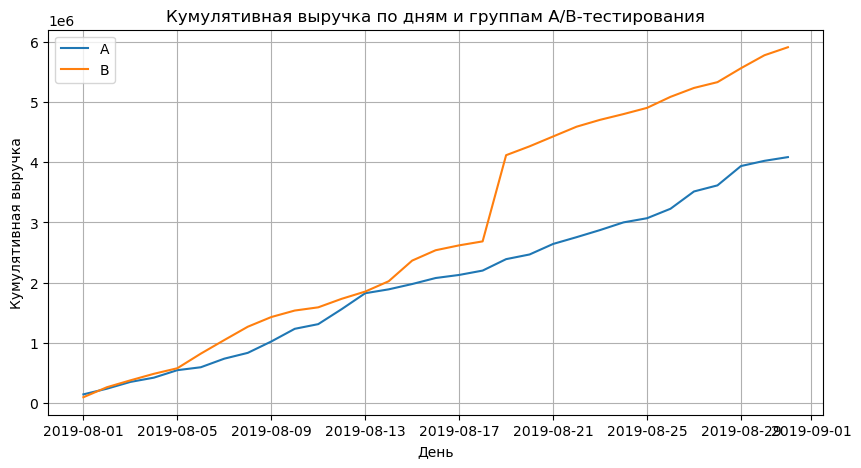

In [22]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# задаем размер графика
plt.figure(figsize=(10, 5))

# строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.title('Кумулятивная выручка по дням и группам A/B-тестирования')
plt.xlabel('День')
plt.ylabel('Кумулятивная выручка')
plt.grid()
plt.legend()
plt.show()

Выручка увеличивается на протяжении всего теста в обеих группах, причем в группе В кумулятивная выручка оказывается выше практически все время. Однако на графиках наблюдаются несколько точек резкого роста (13.08.2019 у группы А и 19.08.2019 у группы В). Вероятно, в эти дни количество заказов было значительно больше обычного либо были заказаны очень дорогие товары. Необходимо будет дополнительно проанализировать влияние выбросов.

### Построение графика кумулятивного среднего чека по группам

Для построения графика среднего чека по группам разделим кумулятивную выручку на кумулятивное число заказов в каждой группе.

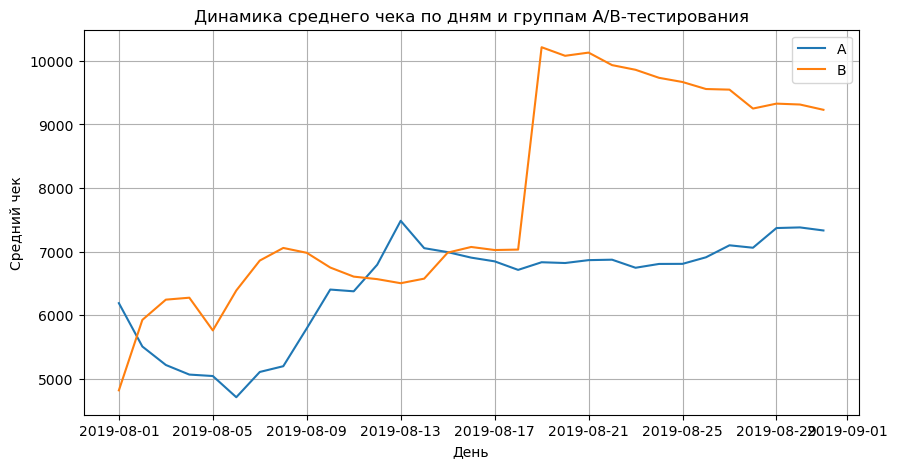

In [23]:
# задаем размер графика
plt.figure(figsize=(10, 5))

# строим график среднего чека группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')

# строим график среднего чека группы В
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')


plt.title('Динамика среднего чека по дням и группам A/B-тестирования')
plt.xlabel('День')
plt.ylabel('Средний чек')
plt.grid()
plt.legend()
plt.show()

Средний чек становится более или менее равномерным ближе к концу теста, причем у группы В размер чека к концу теста снижается. Наблюдался резкий рост 19.08.2019, когда, очевидно, были сделаны очень крупные заказы. В группе А наблюдался пик 13.08.2019 - вероятно, здест так же был сделан аномально дорогой заказ.

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного различия для среднего чека.

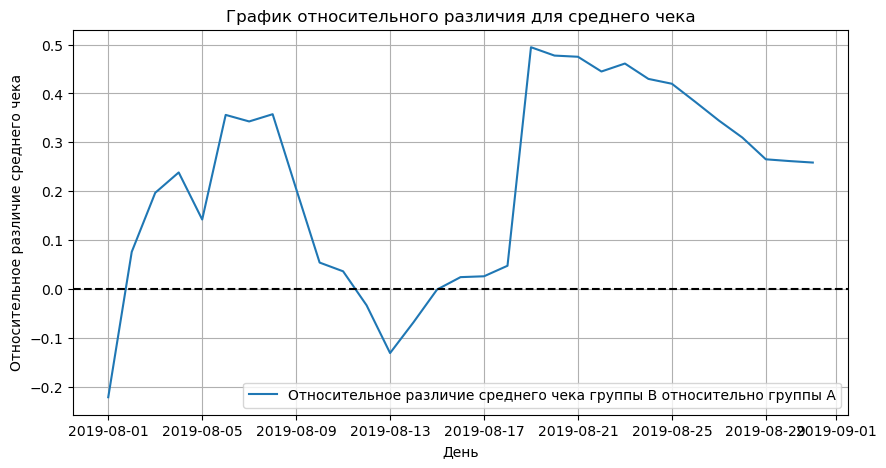

In [24]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

# cтроим отношение средних чеков
# задаем размер графика
plt.figure(figsize=(10, 5))

plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])/(merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a'])-1, label="Относительное различие среднего чека группы B относительно группы A")

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного различия для среднего чека')
plt.xlabel('День')
plt.ylabel('Относительное различие среднего чека')
plt.grid()
plt.legend()
plt.show()

В первые дни теста средний чек в группе В превышал средний чек в группе А, затем произошло несколько скачков (подтверждают наличие аномалий), затем график более или менее выровнялся, причем средний чек в группе В демонстирует постепенное снижение по отношению к среднему чеку в группе А.

### Построение графика кумулятивного среднего количества заказов на посетителя по группам

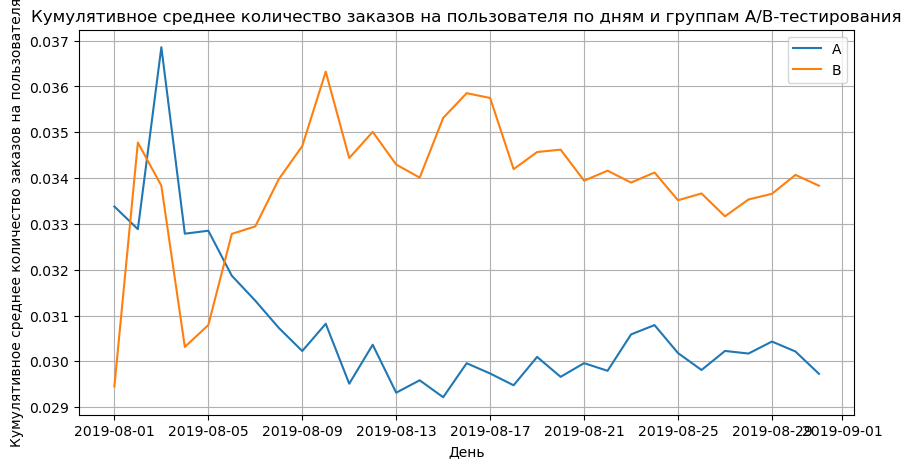

In [25]:
# считаем кумулятивное среднее количество заказов на пользователя
cumulative_data['orders_per_visitor'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
# задаем размер графика
plt.figure(figsize=(10, 5))

plt.plot(cumulative_data_a['date'], cumulative_data_a['orders_per_visitor'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['orders_per_visitor'], label='B')
plt.legend()

plt.title('Кумулятивное среднее количество заказов на пользователя по дням и группам A/B-тестирования')
plt.xlabel('День')
plt.ylabel('Кумулятивное среднее количество заказов на пользователя')
plt.grid()
plt.legend()
plt.show()

В первые дни теста кумулятивное среднее количество заказов на пользователя резко увеличилось в обеих группах, причем это значение в группе А было выше, чем в группе В. Спустя несколько дней среднее количество заказов на пользователя в группе В превысило среднее количество заказов на пользователя в группе А и оставалось выше до окончания теста.

### Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

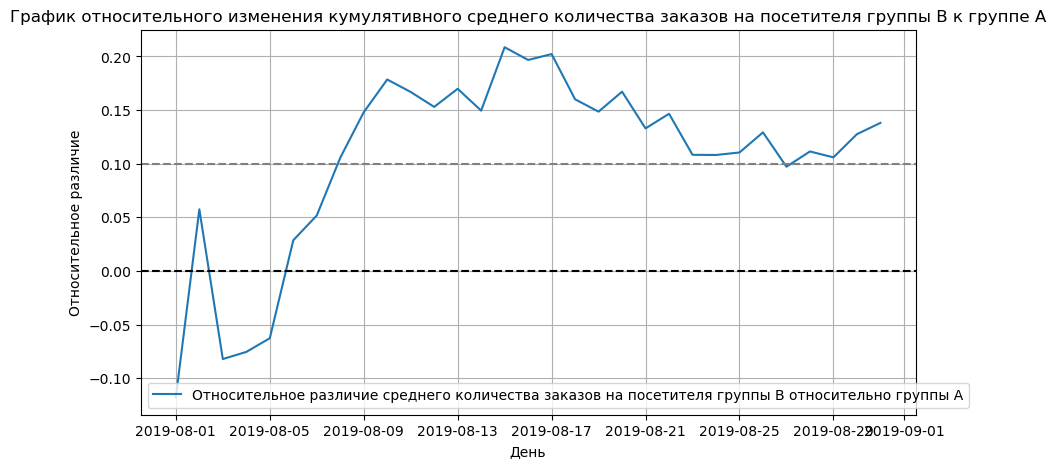

In [26]:
# объединеяем данные по обеим группам
merged_cumulative_conversions = cumulative_data_a[['date','orders_per_visitor']].merge(cumulative_data_b[['date','orders_per_visitor']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

# задаем размер графика
plt.figure(figsize=(10, 5))

plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['orders_per_visitor_b']/merged_cumulative_conversions['orders_per_visitor_a']-1, label="Относительное различие среднего количества заказов на посетителя группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы В к группе А')
plt.xlabel('День')
plt.ylabel('Относительное различие')
plt.grid()
plt.show()


В начале теста относительный прирост среднего количества заказов на посетителя в группе В относительно группы А возрастал, затем произошел спад, после которого начался рост относительного прироста, сохранившийся до конца теста.

На первый взгляд, группа В демонстирует более хорошие показатели, чем группа А. Но для окончательных выводов необходимо обработать аномалии, для чего изучим распределение количества заказов на пользователя и стоимость заказов.

### Построение графиков количества заказов по пользователям

In [27]:
# посчитаем количество заказов по пользователям и посмотрим на результат:

orders_by_visitors = (orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'}))

orders_by_visitors.columns = ['visitor_id', 'orders']

orders_by_visitors.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Максимальное количество заказов от одного пользователя 11, но таких пользователей совсем немного. Построим гистограмму распределения количества заказов на одного пользователя.

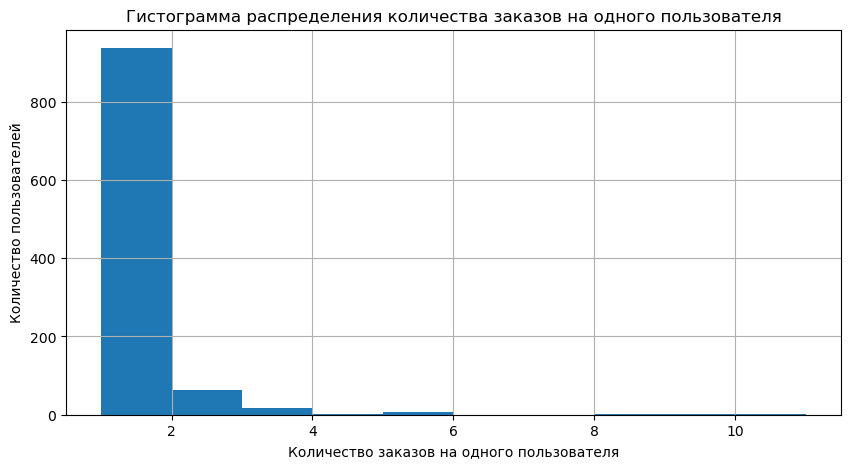

In [28]:
plt.figure(figsize=(10, 5))
plt.hist(orders_by_visitors['orders'])
plt.title('Гистограмма распределения количества заказов на одного пользователя')
plt.xlabel('Количество заказов на одного пользователя')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

Большинство пользователей делали 1 заказ, но количество пользователей с 2-5 заказми тоже достаточно велико.

Построим точечную диаграмму числа заказов на одного пользователя.

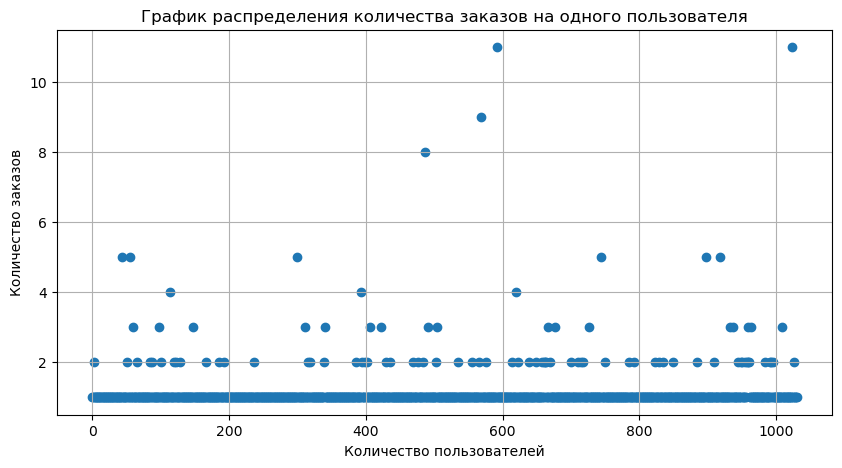

In [29]:
plt.figure(figsize=(10, 5))
x_values = pd.Series(range(0,len(orders_by_visitors)))

plt.scatter(x_values, orders_by_visitors['orders'])

plt.title('График распределения количества заказов на одного пользователя')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

Как было показано выше, подавляющее большинство посетителей делают 1 заказ, но есть определенное количество пользователей с 2-5 заказами. Посчитаем выборочные перцентили количества заказов, чтобы определить границу аномалий. 

In [30]:
np.percentile(orders_by_visitors['orders'], [90, 95, 99])

array([1., 2., 4.])

Не более 5% пользователей сделали больше 2 заказов и не более 1% - больше 4. Примем за верхнюю границу отсечения 95 персентиль - пользователей, которые сделали больше 2 заказов.

### Построение графиков стоимости заказов

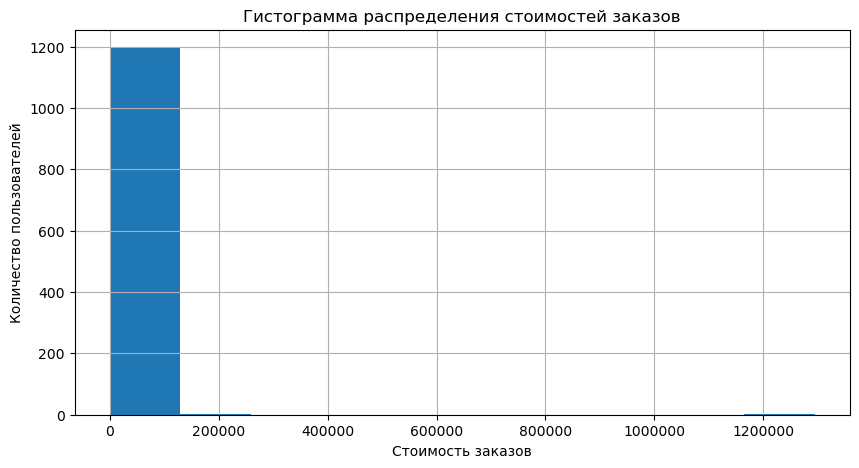

In [31]:
# строим гистограмму распределения стоимости заказов: 

plt.figure(figsize=(10, 5))
plt.ticklabel_format(style='plain')
plt.hist(orders['revenue']) 

plt.title('Гистограмма распределения стоимостей заказов')
plt.xlabel('Стоимость заказов')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

В данных есть ряд заказов с аномально высокой стоимостью. Стоимость большинства заказов находится в пределах 100000.

Количество аномальных заказов оценим с помощью точечного графика.

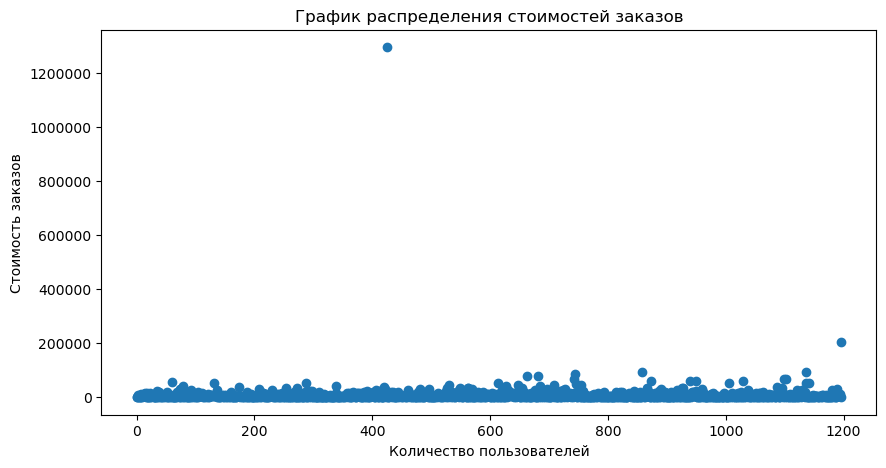

In [32]:
plt.figure(figsize=(10, 5))
plt.ticklabel_format(style='plain')
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('График распределения стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')

plt.show()

На графике мы видим два выбивающихся заказа дороже 200000. Посмотрим, когда они были сделаны.

In [33]:
orders[orders['revenue'] > 200000]

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B


19.08.2019 - именно в этой точке мы наблюдали резкий рост среднего чека в группе В. Рост также наблюдался и в точке 15.08.2019. Рассмотрим распределение стоимостей заказов без этих значений, а также рассмотрим выборочные перцентили для установления верхнего порога отсечения.

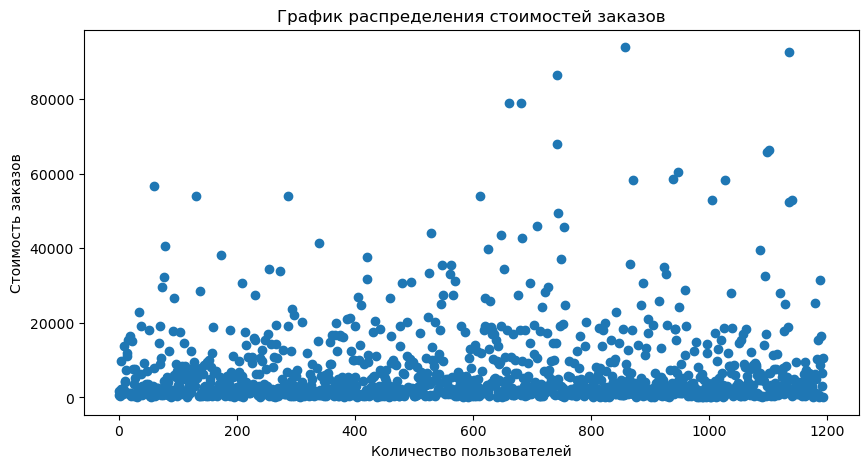

In [34]:
plt.figure(figsize=(10, 5))
plt.ticklabel_format(style='plain')
x_values = pd.Series(range(0,len(orders[orders['revenue'] < 200000]['revenue'])))
plt.scatter(x_values, orders[orders['revenue'] < 200000]['revenue'])
plt.title('График распределения стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')

plt.show()

In [35]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

Не более 5% пользователей совершили покупку дороже 28000 и не более 1% - дороже 58234. Примем за верхнюю границу отсечения 95 персентиль - пользователей, которые сделали заказы дороже 28000.

### Промежуточный итог

Таким образом, мы визуально оценили результаты A/B-теста и предварительно предполагаем, что в группе В показатели лучше, чем в группе А. При этом мы также выяснили, что в данных есть выбросы и определили границу для их определения. Можем приступить к расчету статистической значимости различий в среднем количестве заказов на посетителя и среднем чеке заказа между группами по сырым и очищенным данным.

### Подготовка данных для расчета статистической значимости различий между группами

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по сырым данным

Сформулируем гипотезы.
- нулевая гипотеза: различий в среднем количестве заказов на посетителя между группами нет
- альтернативная гипотеза: различия в среднем количестве заказов на посетителя между группами есть

Создадим переменные `orders_by_users_a` и `orders_by_users_b` со столбцами `'user_id'`, `'orders'`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [36]:
orders_by_users_a = (orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique}))
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique}))
orders_by_users_b.columns = ['visitor_id', 'orders']

Объявим переменные `sample_a` и `sample_b` в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. 

In [37]:
sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)

print(len(sample_a), len(sample_b))

18736 18916


Проверим для начала, насколько нормально распределены данные. Применим критерий Шапиро-Уилка, но оценивать будем не по p-value, а по статистике самого теста (так как в обеих выборках больше 5000 элементов, p-value может отображаться некорректно). Чем ближе статистика к 1, тем более вероятно, что величина распределена нормально.

In [38]:
print(stats.shapiro(sample_a)[0])
print(stats.shapiro(sample_b)[0])

0.13177603483200073
0.1508488655090332


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Статистика далека от 1, распределение данных не является нормальным, поэтому для проверки гипотез будем использовать непараметрический тест Уилкоксона-Манна-Уитни.

In [39]:
# проверяем гипотезу

# задаем стандартный уровень статистической значимости
alpha = 0.05

results = stats.mannwhitneyu(sample_a, sample_b)

print('Нулевая гипотеза: различий в среднем количестве заказов на посетителя между группами нет')
print('Альтернативная гипотеза: различия в среднем количестве заказов на посетителя между группами есть')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница в среднем количестве заказов на посетителя между группами статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии среднего количества заказов на посетителя между группами сделать нельзя') 

# рассчитаем соотношение среднего количества заказов на посетителя в группе В относительно среднего количества заказов на посетителя в группе А   
print(f'В группе В среднее количество заказов на посетителя на {round(100*(sample_b.mean() / sample_a.mean() - 1), 2)}% больше, чем в группе А')

Нулевая гипотеза: различий в среднем количестве заказов на посетителя между группами нет
Альтернативная гипотеза: различия в среднем количестве заказов на посетителя между группами есть
p-значение:  0.016792355056752608
Отвергаем нулевую гипотезу: разница в среднем количестве заказов на посетителя между группами статистически значима
В группе В среднее количество заказов на посетителя на 13.81% больше, чем в группе А


Таким образом, на заданном уровне статистической значимости (5%) сырые данные показывают наличие статистически значимой разницы между группами.  В группе В в среднем заказов на одного посетителя больше, чем в группе А.

#### Расчет статистической значимости различий в среднем чеке заказа между группами по сырым данным

Сформулируем гипотезы.
- нулевая гипотеза: различий в среднем чеке заказа между группами нет
- альтернативная гипотеза: различия в среднем чеке заказа между группами есть

Для начала также проверим распределение данных. на нормальность.

In [40]:
alpha = 0.05

results = stats.shapiro(orders[orders['group']=='A']['revenue'])
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение нормально') 

p-значение:  1.739723833199812e-34
Отвергаем нулевую гипотезу: распределение не нормально


In [41]:
alpha = 0.05

results = stats.shapiro(orders[orders['group']=='B']['revenue'])
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение нормально') 

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Распределения суммы чеков в группах не являются нормальными, поэтому для проверки гипотезы также используем тест Уилкоксона-Манна-Уитни.

In [42]:
alpha = 0.05

a_revenue = orders[orders['group']=='A']['revenue']
b_revenue = orders[orders['group']=='B']['revenue']
results = stats.mannwhitneyu(a_revenue, b_revenue)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница в среднем чеке заказа между группами статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии среднего чека заказа между группами сделать нельзя') 

# рассчитаем соотношение среднего чека заказа в группе В относительно среднего чека заказа в группе А     

print(f'В группе В средний чек заказа на {round(100*(b_revenue.mean() / a_revenue.mean() - 1), 2)}% больше, чем в группе А')

p-значение:  0.7292909855432458
Не получилось отвергнуть нулевую гипотезу, вывод о различии среднего чека заказа между группами сделать нельзя
В группе В средний чек заказа на 25.87% больше, чем в группе А


Несмотря на то, что средний чек заказа значительно выше в группе В, чем в группе А, статистически средние чеки в группах не отличаются. Наиболее вероятно то, что на величину среднего чека в группе В сильно влияют выявленные выбросы.

#### Выявление аномальных пользователей

Границы для отсечения пользователей:
- больше 2 заказов
- заказы дороже 28000

In [43]:
# пользователи с большим количеством заказов
many_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders'] > np.percentile(orders_by_visitors['orders'], 95)]['visitor_id'],
                         orders_by_users_b[orders_by_users_b['orders'] > np.percentile(orders_by_visitors['orders'], 95)]['visitor_id']], axis=0)
                         
# пользователи с дорогими заказами
expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitor_id']

# объединяем аномальных пользователей
abnormal_users = (pd.concat([many_orders, expensive_orders], axis=0).drop_duplicates().sort_values())

Посчитаем аномальных пользователей и определим их долю среди общего количества уникальных покупателей, чтобы оценить потери данных после удаления.

In [44]:
print(f'Всего аномальных покупателей: {len(abnormal_users)}. Их доля от общего количества уникальных покупателей: {round(100 * len(abnormal_users) / total_unique_buyers, 2)}%.')

Всего аномальных покупателей: 74. Их доля от общего количества уникальных покупателей: 7.18%.


Потери данных после фильтрации составят 7,18% уникальных покупателей. Отфильтруем данные и проверим гипотезы еще раз, чтобы понять, насколько такие аномальные покупатели влияют на результаты теста.

#### Очистка данных от аномалий

In [45]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по очищенным данным

In [46]:
alpha = 0.05

results = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)

print('Нулевая гипотеза: различий в среднем количестве заказов на посетителя между группами нет')
print('Альтернативная гипотеза: различия в среднем количестве заказов на посетителя между группами есть')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница в среднем количестве заказов на посетителя между группами статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии среднего количества заказов на посетителя между группами сделать нельзя') 

# рассчитаем соотношение среднего количества заказов на посетителя в группе В относительно среднего количества заказов на посетителя в группе А   
print(f'В группе В среднее количество заказов на посетителя на {round(100*(sample_b_filtered.mean() / sample_a_filtered.mean() - 1), 2)}% больше, чем в группе А')

Нулевая гипотеза: различий в среднем количестве заказов на посетителя между группами нет
Альтернативная гипотеза: различия в среднем количестве заказов на посетителя между группами есть
p-значение:  0.013042592743036745
Отвергаем нулевую гипотезу: разница в среднем количестве заказов на посетителя между группами статистически значима
В группе В среднее количество заказов на посетителя на 17.27% больше, чем в группе А


Как и в случае с сырыми данными, наблюдается статистически значимая разница в среднем количестве заказов на посетителя между группами. Как и ранее, в группе В заказов на посетителя больше, чем в группе А.

#### Расчет статистической значимости различий в среднем чеке заказа между группами по очищенным данным

In [47]:
alpha = 0.05

a_revenue_filtered = orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']
b_revenue_filtered = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']

results = stats.mannwhitneyu(a_revenue_filtered, b_revenue_filtered)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница в среднем чеке заказа между группами статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии среднего чека заказа между группами сделать нельзя') 

# рассчитаем соотношение среднего чека заказа в группе В относительно среднего чека заказа в группе А     

print(f'В группе В средний чек заказа на {round(100*(b_revenue_filtered.mean() / a_revenue_filtered.mean() - 1), 2)}% больше, чем в группе А')

p-значение:  0.738481751314565
Не получилось отвергнуть нулевую гипотезу, вывод о различии среднего чека заказа между группами сделать нельзя
В группе В средний чек заказа на -1.96% больше, чем в группе А


На очищенных данных тест также не выявил статистически значимых различий в средних чеках между группами. А вот соотношение после удаления аномальных пользователей изменилось - средний чек в группе В чуть ниже, чем в группе А.

## Вывод

### Общее описание проекта
Для анализа были предоставлены данные о 9 гипотезах (таблица `hypothesis`), а также результаты A/B-теста, проводимого в период с 1 по 31 августа 2019 года, в виде таблиц с данными о заказах и посетителях интернет-магазина (таблицы `orders` и `visitors`). Необходимо было провести приоритизацию гипотез и проанализировать результаты теста, чтобы принять решение о его продолжении и успехе.

### Предобработка данных
Дубликаты и пропуски в таблицах отсутствовали. Была выполнена проверка соответствия дат в таблицах с заказами и посетителями (даты совпадают). Столбы `date` в таблицах `orders` и `visitors` приведены к типу `datetime`.

### Приоритизация гипотез
Данные в таблице `hypothesis` позволяли провести приоритизацию гипотез методами ICE и RICE. По итогам оценки методом ICE были выявлены три наиболее приоритетные гипотезы (по уменьшению приоритета):
- гипотеза 8: Запустить акцию, дающую скидку на товар в день рождения
- гипотеза 0: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- гипотеза 7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Однако использование метода RICE показало другой результат (по уменьшению приоритета):
- гипотеза 7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- гипотеза 2: Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- гипотеза 0: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- гипотеза 6: Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

Наиболее перспективная в первом случае гипотеза 8 проигрывает по потенциальному охвату аудитории другим гипотезам. Для проверки рекомендуется выбрать гипотезы 7 и 0.

### Анализ A/B-теста
#### Проверка правильности проведения A/B-теста
Была проведена оценка размеров групп тестирования. Размер группы А: 18736. Размер группы В: 18916. Размеры групп не равны, но достаточно близки.

Уникальных покупателей из группы А: 503. Уникальных покупателей из группы В: 586. Общее количество уникальных покупателей: 1031. таким образом, 58 покупателей (5,6% от общего количества) попали и в ту, и в другую группу. Так как этих посетителей невозможно идентифицировать в таблице `visitors`дальнейшие расчеты ведутся с учетом их присутствия.

Для того, чтобы исключить проблему подглядывания, была составлена таблица с кумулятивными данными (накопленные количество заказов, количество покупателей, выручка, количество пользователей на каждый день в каждой группе).

#### Изучение графика кумулятивной выручки по группам
График кумулятивной выручки по группам показал рост в обеих группах, причем в группе В кумулятивная выручка была стабильна выше, чем в группе А. При этом было отмечено несколько точек резкого роста, свидетельствующих о наличии аномалий в данных.

#### Изучение графика графика кумулятивного среднего чека по группам
Графики средних чеков становятся более или менее равномерными к концу теста, причем у группы В размер среднего чека снижается. Отмечаются точки резкого роста: 19.08.2019 в группе В и 13.08.2019 в группе А. 

#### Изучение графика графика относительного изменения кумулятивного среднего чека группы B к группе A
В начале теста средний чек в группе В был выше, чем в группе А. В точках аномалий произошли резкие изменения, затем график начал выравниваться. При этом средний чек в группе В постепенно уменьшается по сравнению со средним чеком в группе А.

#### Изучение графика кумулятивного среднего количества заказов на посетителя по группам
В начале теста наблюдались флуктуации среднего количества заказов на посетителя в обеих группах. Затем на фоне снижения среднего количества заказов на посетителя в группе А этот показатель в группе В увеличился и оставался стабильно выше до окончания теста. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A подтверждает это наблюдение.

#### Выявление и устранение аномалий
Были изучены гистограмы и точечные графики рапределения количества заказов на одного пользователя и стоимости заказов. Выявлены аномально высокие значения. По итогам изучения выборочных перцентилей выделены следующие верхние границы отсечения данных:
- количество заказов: 2 (95 перцентиль)
- сумма заказа: 28000 (95 перцентиль)

#### Расчет статистической значимости различий в группах по сырым данным
Были подготовлены данные для расчета статистической значимости различий в среднем количестве заказов на посетителя и в среднем чеке заказа между группами. Критерий Шапиро-Уилка показал, что распределение данных не является нормальным, в связи с чем выявление значимости различий проводилось с помощью непараметрического теста Уилкоксона-Манна-Уитни.

##### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами
Тест на сырых данных и уровне значимости 5% показал наличие статистически значимой разницы в среднем количестве заказов на посетителя между группами. В группе В на в среднем заказов на посетителя больше на 13.81%.

##### Расчет статистической значимости различий в среднем чеке заказа между группами
Несмотря на то, что средний чек в группе В на 25.87% больше, чем в группе А, тест на сырых данных и уровне значимости 5% показал отсутствие статистически значимой разницы между группами.

#### Расчет статистической значимости различий в группах по очищенным данным
##### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами
Тест на очищенных данных также показал наличие наличие статистически значимой разницы в среднем количестве заказов на посетителя между группами. В группе В в данном случае заказов больше на 17.27% .

##### Расчет статистической значимости различий в среднем чеке заказа между группами
Тест на очищенных данных также не выявил наличие статистически значимой разницы между группами. При этом средний чек в группе В на 1.96% ниже, чем в группе А.

#### Итого
Так как графики показателей среднего чека и среднего количества заказов на посетителя выровнялись к концу теста, можно считать, что длительность теста была достаточной для того, чтобы выбросы показателей успели компенсироваться. Проблема подсматривания была решена путем использования кумулятивных данных. Таким обзом, A/B-тест был проведен корректно, его можно остановить и зафиксировать его результаты:
- среднее количество заказов на посетителя: выше в группе В
- средний чек: значимой разницы между группами не выявлено